In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)
df,final_data = load_all(plates)

def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
    
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instand_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)

Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']

final_data = final_data.reset_index(drop=True)
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}

n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code

In [2]:
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2

In [3]:
select = final_data
select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
select= select[select['time_hour_binned']<=160]
select= select[select['instant_SA_dens']<=8e4]
select= select[select['instant_SA_dens']>0]
summary = select.groupby("strain")[['hull_speed','instant_SA_dens','radius','instant_BV_dens','instant_L_dens']].median()
summary['size_point'] = 20
summary['fungus'] = summary.index
summary

,hull_speed,instant_SA_dens,radius,instant_BV_dens,instant_L_dens,size_point,fungus
strain,,,,,,,
A5,243.356621,14558.291259,2.122073,20595.006116,812.303656,20,A5
Agg,181.522359,46103.580548,1.535025,57774.116180,3526.005463,20,Agg
C2,228.367148,26230.768237,1.988979,36628.938461,1730.709783,20,C2
C3,255.010529,23266.414599,2.043482,33718.377793,1393.264730,20,C3
Clarum,235.830278,20352.414546,2.053692,30965.190352,1192.316399,20,Clarum


In [5]:
couples = [(row['hull_speed'],row['instant_SA_dens'],row['instant_BV_dens'],row['instant_L_dens'],index) for index, row in summary.iterrows()]
couples_units = [(c*1e-4*24,(rho_SA*1e-6)*rho_L*1e-3*1e-2*1e3,(rho_BV*1e-9)*rho_L*1e-3,strain) for (c,rho_SA,rho_BV,rho_L,strain) in couples]
couples_units = sorted(couples_units)
couples_units #cm/day, cm**2/cm**3,mm**3/mm**3

[(0.43565366051376, 1.6256147687996523, 0.00020371184927764325, 'Agg'),
 (0.54808115463912, 0.4539784719751536, 6.339406212626016e-05, 'C2'),
 (0.56599266706392, 0.2426651761352493, 3.692030424046138e-05, 'Clarum'),
 (0.5840558903580001, 0.11825753215459969, 1.672939876375229e-05, 'A5'),
 (0.6120252701073601, 0.3241627484892628, 4.69786265246686e-05, 'C3')]

In [6]:
from scipy.integrate import odeint
from matplotlib.pyplot import cm

Fmax = 0.4 #ug.cm**-2.h-1
Km = 1e-3 #ug.cm**-3
Fmax *= (24)#ug.cm**-2.day-1
n = 30
color = cm.Blues(np.linspace(0, 1, n))
color2 = cm.Reds(np.linspace(0, 1, n))
def make_rho(rho0,c):
    def rho(x,t):
        return(rho0*1/(1+np.exp(np.exp(x-c*t))))
    return(rho)
def find_integral(rho0,c,C0,plot = True):
    rho_f = make_rho(rho0,c)
    max_xs = 25
    nxs = 1000
    xs = np.linspace(0,max_xs,nxs)
    maxt = 28
    ts = np.linspace(0,maxt,n)
#     if plot:
#         fig,ax = plt.subplots()

#         for i,t in enumerate(ts):
#             y = rho_f(xs,t)
#             ax.plot(xs,y,c=color[i])
    def make_model(x):
        def model(y,t):
            rho = rho_f(x,t)
            dydt = -rho*Fmax*y/(Km+y)
            # dydt = -coeff*rho*Fmax*y

            return dydt
        return(model)
    Cs = []


    for x in xs:
        model = make_model(x)
        C = odeint(model,C0,ts)
        Cs.append(C)
    Cs = np.array(Cs)
    if plot:
    
        fig,ax = plt.subplots()
        ax2=ax.twinx()
        ratio = 4 
        for i,t in enumerate(ts[::ratio]):
            ax2.plot(xs,Cs[:,ratio*i],c=color2[ratio*i])
            y = rho_f(xs,t)
            ax.plot(xs,y,c=color[ratio*i])
        ax.set_ylabel(r'density $\rho$ $(cm^2.cm^{-3})$',color='blue')
        ax.set_xlabel('distance $(cm)$')
        
        ax.tick_params(axis = 'y',colors = 'blue')
        ax2.set_ylabel('P concentration $C$ $(\mu g .cm^{-3})$',color='red')
        ax2.tick_params(axis = 'y',colors = 'red')    
        plt.tight_layout()
        fig,ax = plt.subplots()
        for i,t in enumerate(ts[::ratio]):
            y =Cs[:,ratio*i][:,0]
            ax.plot(xs,rho_f(xs,t)*Fmax*y/(Km+y),c=color[ratio*i])
        ax.set_xlabel('distance $(cm)$')
        ax.set_ylabel('absorption rate \n $(\mu g.cm^{-3}.day^{-1})$',color='blue')
        plt.tight_layout()
    integrals = []
    for i,t in enumerate(ts):
        y =Cs[:,i][:,0]
        curve = rho_f(xs,t)*Fmax*y/(Km+y)
        integrals.append(2*np.pi*np.sum(curve*xs)*max_xs/nxs)
    if plot:
        fig,ax = plt.subplots()
        ax.plot(ts,integrals)
        ax.set_xlabel('time (day)')
        ax.set_ylabel('Colony absorption rate \n $(\mu g.day^{-1}.cm^{-1})$')
        plt.tight_layout()
    return(integrals)

C:\Users\coren\AppData\Local\Temp\ipykernel_3596\3967670941.py:12: RuntimeWarning: overflow encountered in exp
  return(rho0*1/(1+np.exp(np.exp(x-c*t))))


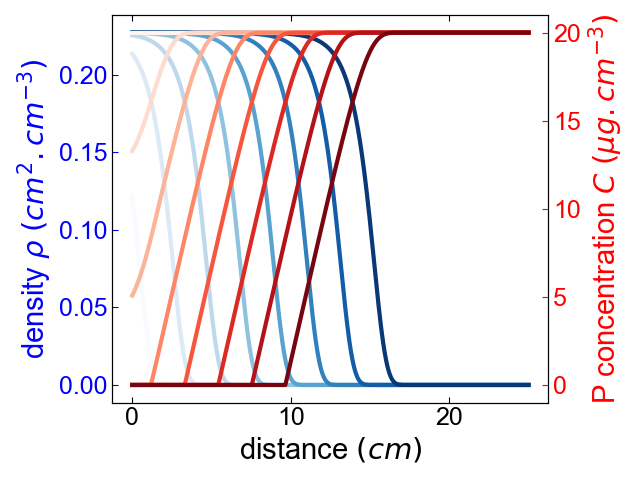

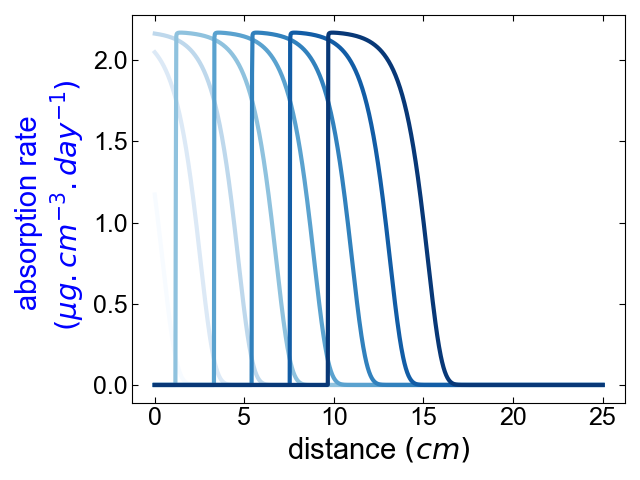

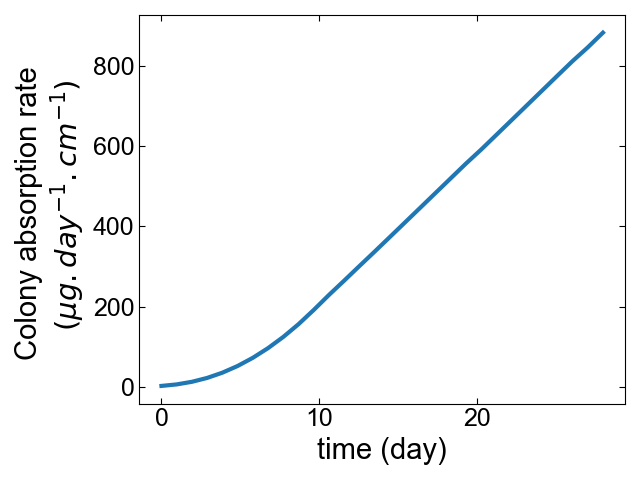

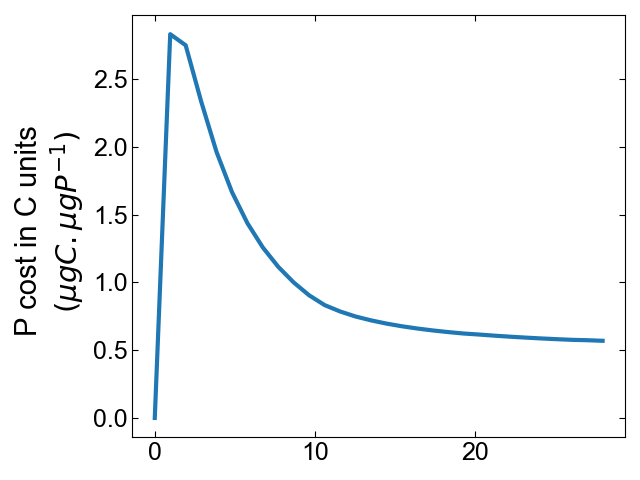

In [7]:
(c,rho0,rho1,strain) = couples_units[1]

C0 = 20
integrals = find_integral(rho0,c,C0,plot=True)
maxt = 28
ts = np.linspace(0,maxt,n)
biovolumes = 2*rho1*(c**2*1e2*ts)*np.pi #mm3/mm/day
biomasses = biovolumes*1e-6 #kg/mm/day
dry_biomasses = 0.3*biomasses #kg/mm/day
C_mass = dry_biomasses*0.5 #kg C/mm/day
C_mass = C_mass*1e9 #ugC/mm/day
C_mass_invest = C_mass*10 #ugC/cm/day
fig,ax = plt.subplots()
ax.plot(ts,C_mass_invest/integrals)
ax.set_ylabel('P cost in C units \n $(\mu g C.\mu gP^{-1})$')
plt.tight_layout()


C:\Users\coren\AppData\Local\Temp\ipykernel_3596\3967670941.py:12: RuntimeWarning: overflow encountered in exp
  return(rho0*1/(1+np.exp(np.exp(x-c*t))))


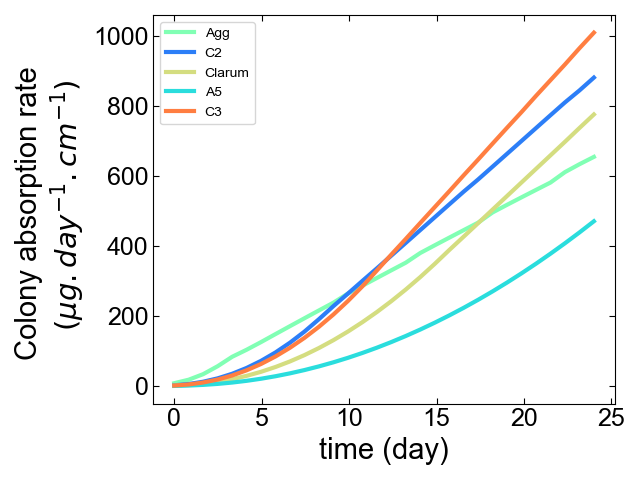

In [8]:
C0= 20
integrals_limit = []
strains = []
for (c,rho0,rho1,strain) in couples_units:
    integrals_limit.append(find_integral(rho0,c,C0,plot=False))
    strains.append(strain)
fig,ax = plt.subplots()
maxt = 24
ts = np.linspace(0,maxt,n)
for j,(c,rho0,rho1,strain) in enumerate(couples_units):
    ax.plot(ts,integrals_limit[j],label=strains[j],color = strain_to_color[strain])
    # ax.plot(ts,integrals_limit[j],color = colors[j])
    
ax.legend()
ax.set_xlabel('time (day)')
ax.set_ylabel('Colony absorption rate \n $(\mu g.day^{-1}.cm^{-1})$')
plt.tight_layout()

In [9]:
maxt = 28
ts = np.linspace(0,maxt,n)
C0s = [1,10,50]
integrals_limit_list = []
costs_limit_list = []

for C0 in C0s:
    integrals_limit = []
    costs_limit = []
    for j,(c,rho0,rho1,strain) in enumerate(couples_units):
        integral = find_integral(rho0,c,C0,plot=False)
        integrals_limit.append(np.mean(integral))
        biovolumes = 2*rho1*(c**2*1e2*ts)*np.pi #mm3/mm/day
        biomasses = biovolumes*1e-6 #kg/mm/day
        dry_biomasses = 0.3*biomasses #kg/mm/day
        C_mass = dry_biomasses*0.5 #kg C/mm/day
        C_mass = C_mass*1e9 #ugC/mm/day
        C_mass_invest = C_mass*10 #ugC/cm/day
        
        costs_limit.append(np.mean(C_mass/integral))
        
    integrals_limit_list.append(integrals_limit)
    costs_limit_list.append(costs_limit)

C:\Users\coren\AppData\Local\Temp\ipykernel_3596\3967670941.py:12: RuntimeWarning: overflow encountered in exp
  return(rho0*1/(1+np.exp(np.exp(x-c*t))))


In [10]:
strains = [strain for (c,rho0,rho1,strain) in couples_units]
cs = [c for (c,rho0,rho1,strain) in couples_units]

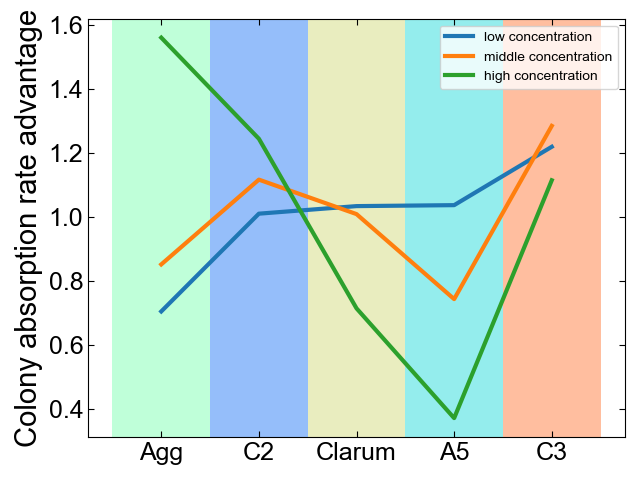

In [11]:
fig,ax = plt.subplots()
labels = ['low concentration','middle concentration','high concentration']
strain_positions = {strain: i for i, strain in enumerate(strains)}

# Adding background colors for each strain
for strain, pos in strain_positions.items():
    color = strain_to_color.get(strain, 'default_color')
    ax.axvspan(pos - 0.5, pos + 0.5, facecolor=color, alpha=0.5)
for j,C0 in enumerate(C0s):
    ax.plot(strains,np.array(integrals_limit_list[j])/np.mean(integrals_limit_list[j]),label=labels[j])
    
    # ax.plot(strains,np.array(integrals_limit_list[j])/np.mean(integrals_limit_list[j]),label=f'$C_0 =$ {C0} $ \mu mol.cm^{-3}$')
ax.legend()
ax.set_ylabel('Colony absorption rate advantage')
plt.tight_layout()

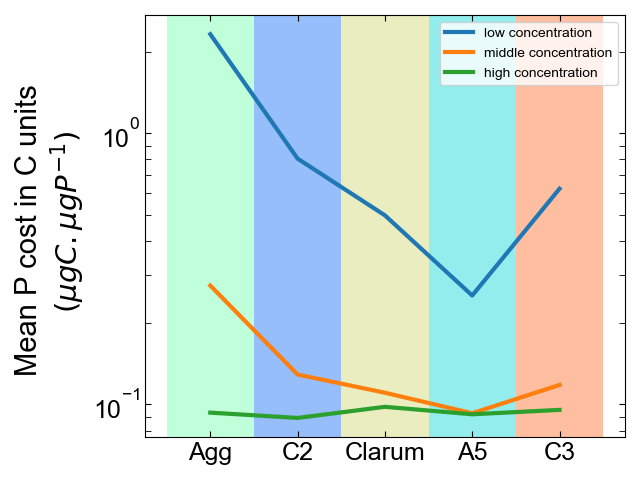

In [12]:
fig,ax = plt.subplots()

for j,C0 in enumerate(C0s):
    ax.plot(strains,np.array(costs_limit_list[j]),label=labels[j])
for strain, pos in strain_positions.items():
    color = strain_to_color.get(strain, 'default_color')
    ax.axvspan(pos - 0.5, pos + 0.5, facecolor=color, alpha=0.5)
    # ax.plot(strains,np.array(costs_limit_list[j]),label=f'$C_0 =$ {C0} $ \mu mol.cm^{-3}$')
ax.legend()
ax.set_ylabel('Mean P cost in C units \n $(\mu g C.\mu gP^{-1})$')
ax.set_yscale('log')
plt.tight_layout()

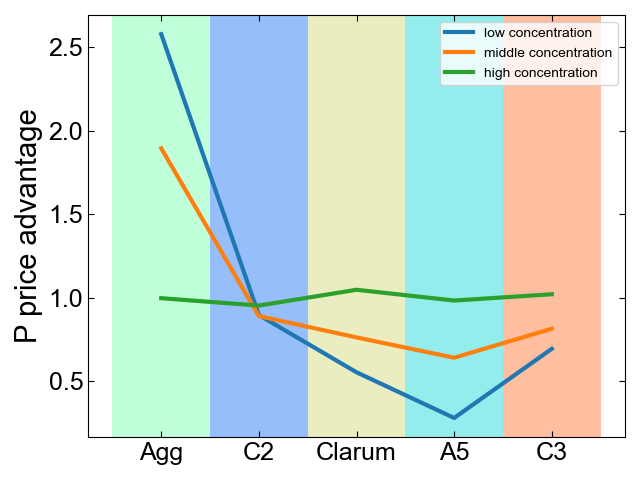

In [13]:
fig,ax = plt.subplots()

for j,C0 in enumerate(C0s):
    ax.plot(strains,np.array(costs_limit_list[j]/np.mean(costs_limit_list[j])),label=labels[j])
for strain, pos in strain_positions.items():
    color = strain_to_color.get(strain, 'default_color')
    ax.axvspan(pos - 0.5, pos + 0.5, facecolor=color, alpha=0.5)
    # ax.plot(strains,np.array(costs_limit_list[j]),label=f'$C_0 =$ {C0} $ \mu mol.cm^{-3}$')
ax.legend()
ax.set_ylabel('P price advantage')
plt.tight_layout()

In [21]:
fixed_price_combo = []
for j,C0 in enumerate(C0s):
    
couples_units_new = [(c,rho0,rho1,strain) for (c,rho0,rho1,strain) in couples_units]


IndentationError: expected an indented block after 'for' statement on line 2 (2153221026.py, line 4)

In [ ]:
X = summary['hull_speed']
y = summary['instant_SA_dens']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Getting the coefficients
intercept, slope = model.params
X = summary['hull_speed']
y = summary['instant_L_dens']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Getting the coefficients
intercept2, slope2 = model.params


In [ ]:
k = 8
speeds = np.linspace(150,250,k )
rho_SAs = speeds*slope + intercept
rho_Ls = speeds*slope2 + intercept2

speeds = speeds*1e-4*24
rho_SAs = (rho_SAs*1e-6)*rho_Ls*1e-3*1e-2*1e3

C0s = np.linspace(1,50,k )

In [ ]:

final = []

for C0 in C0s:
    for j,c in enumerate(speeds):
        row = {}
        row['speed'] = c
        row['C0'] = C0
        
        rho0 = rho_SAs[j]
        integral = find_integral(rho0,c,C0,plot=False)
        row['P_rate'] = np.mean(integral)
        final.append(row)

In [ ]:
df = pd.DataFrame(final)
average_p_rate = df.groupby('C0')['P_rate'].mean()

# Merge the averages back into the original DataFrame
df['average_P_rate'] = df['C0'].map(average_p_rate)
df['normalized_P_rate'] = df['P_rate']/df['average_P_rate']

In [ ]:
pivot_df = df.pivot("speed", "C0", "normalized_P_rate")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")

# Adding labels and title
plt.xlabel('Speed (cm/day)')
plt.ylabel('C0 (ug/mL)')
midpoints = [x + 0.5 for x in range(len(pivot_df.columns))]

# Format the x-axis tick labels to show only the first two digits and set them to the midpoints
xticklabels = [str(label)[:4] for label in pivot_df.columns.values]
plt.xticks(ticks=midpoints, labels=xticklabels)
plt.tight_layout()